# Overview: 

This notebook is created to do tasks given in issue no #9: [Comparing test sample classifications between models](https://github.com/mozilla/PRESC/issues/8)

# Objective:

- How differnt types of NN structures act and differnt results
- Changing hyper-parameters, what are differnt results
- Trying differnt activation fuctions and Optimizers

In [1]:
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow as tf
# Common imports
import numpy as np
import os


from sklearn import metrics
from sklearn.preprocessing import StandardScaler


from IPython.display import clear_output, Image, display, HTML

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
def getAllPreformanceMeasures(output, target):
    target = target.flatten() # if target vector is not one dimentional in axis = 1
    CM = metrics.confusion_matrix(output, target) #creating confusion matrix
    TN = CM[0][0] # True Negatives
    FN = CM[1][0] # False Negatives
    TP = CM[1][1] # True Positives
    FP = CM[0][1] # False Positives
    return (TP+TN)*100/output.shape[0],(TP)*100/(TP+FP),(TP)*100/(TP+FN) # Returns (accuracy, precesion and recall)

In [4]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## Activation function

 When, this output is fed into the further layers, they can be transformed to even larger values, making things computationally uncontrollable. This is where the activation functions play a major role i.e. squashing a real-number to a fix interval (e.g. between -1 and 1). 
 Activation functions address two critical problems in Neural Networks:
- Ensuring that activation maps are non-linear and, thus, independent of each other; and
- Ensuring that some outputs have fundamental numerical properties, for example, being in the [-1, 1] range or being a valid probability distribution.



### Sigmoid or Logistic Activation Function 
The sigmoid activation function has the mathematical form `sig(z) = 1/ (1 + e^-z)`. It basically takes a real valued number as the input and squashes it between 0 and 1. It is often termed as a squashing function as well. It aims to introduce non-linearity in the input space.

### Tanh or hyperbolic tangent Activation Function

The tanh or hyperbolic tangent activation function has the mathematical form `tanh(z) = (e^z — e^-z) / (e^z + e^-z)`. It is basically a shifted sigmoid neuron. It takes a real valued number and squashes it between -1 and +1. 

### ReLU (Rectified Linear Unit) Activation Function

The ReLU or Rectified Linear Unit is represented as `ReLU(z) = max(0, z)`. It basically thresholds the inputs at zero, i.e. all negative values in the input to the ReLU neuron are set to zero. 

### Leaky ReLU

The Leaky ReLU is just an extension of the traditional ReLU function. Instead of defining values less than 0 as 0, we instead define negative values as a small linear combination of the input. The small value commonly used is 0.01.It is represented as `LeakyReLU(z) = max(0.01 * z, z)`.


### ELU

The exponential Linear Unit leads to higher classification results than traditional ReLU. It follows the same rule for x>= 0 as ReLU, and increases exponentially for x < 0.
ELU tries to make the mean activations closer to zero which speeds up training.

### Swish (A Self-Gated) Function

The most important difference from ReLU is in the negative region. Leaky had the same value in ReLU, what was the difference in it? All other activation functions are monotonous. The output of the swish function may fall even when the input increases. This is a swish-specific feature.

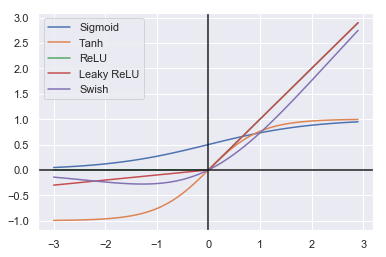

In [57]:
# The definition of activation functions mathematically
# Sigmoid Function
def sigmoid(x):
    a = []
    for i in x:
        a.append(1/(1+math.exp(-i)))
    return a
# Hyperbolic Tanjant Function
def tanh(x, derivative=False):
    if (derivative == True):
        return (1 - (x ** 2))
    return np.tanh(x)
# ReLU Function
def re(x):
    b = []
    for i in x:
        if i<0:
            b.append(0)
        else:
            b.append(i)
    return b
# Leaky ReLU Function
def lr(x):
    b = []
    for i in x:
        if i<0:
            b.append(i/10)
        else:
            b.append(i)
    return b
  
# Determining the intervals to be created for the graph
x = np.arange(-3., 3., 0.1)
sig = sigmoid(x)
tanh = tanh(x)
relu = re(x)
leaky_relu = lr(x)
swish = sig*x

# Displaying the functions
line_1, = plt.plot(x,sig, label='Sigmoid')
line_2, = plt.plot(x,tanh, label='Tanh')
line_3, = plt.plot(x,relu, label='ReLU')
line_4, = plt.plot(x,leaky_relu, label='Leaky ReLU')
line_5, = plt.plot(x,swish, label='Swish')
plt.legend(handles=[line_1, line_2, line_3, line_4, line_5])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Loading Dataset and preprocessing 

In [6]:
creditData = pd.read_csv("../../datasets/defaults.csv")
creditData.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,defaulted
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
continuousCols = ['limit_bal', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
creditData[continuousCols].describe()

,limit_bal,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [8]:
categoricalCols = ["age_range","sex","education","marriage"]

Text(0.5,1,'limit_bal Distribution for two classes')

<Figure size 432x288 with 0 Axes>

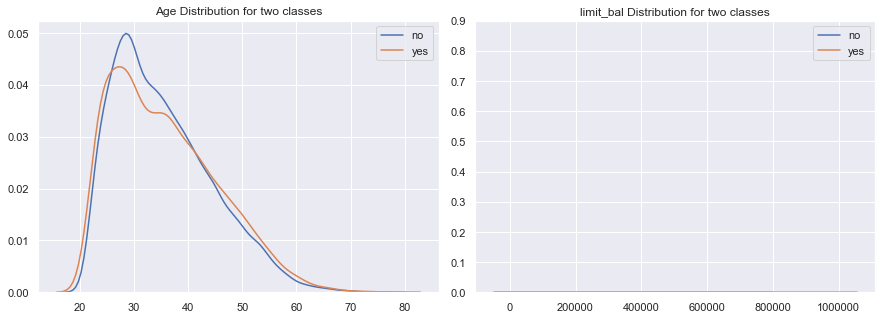

In [9]:
fig = plt.figure(1)
plt.figure(figsize=(15,5))# set up subplot grid
gridspec.GridSpec(1,4)
plt.subplot2grid((1,4), (0,0), colspan=2, rowspan=1)
sns.kdeplot(creditData.loc[creditData["defaulted"]==0,"age"].values, label="no")
sns.kdeplot(creditData.loc[creditData["defaulted"]==1,"age"].values, label="yes")
plt.legend();
plt.title("Age Distribution for two classes")
plt.subplot2grid((1,4), (0,2), colspan=2, rowspan=1)
sns.kdeplot(creditData.loc[creditData["defaulted"]==0,"limit_bal"].values, label="no")
sns.kdeplot(creditData.loc[creditData["defaulted"]==1,"limit_bal"].values, label="yes")
plt.ylim([0,0.9])
plt.legend();
plt.title("limit_bal Distribution for two classes")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002885506C898>,
      dtype=object)

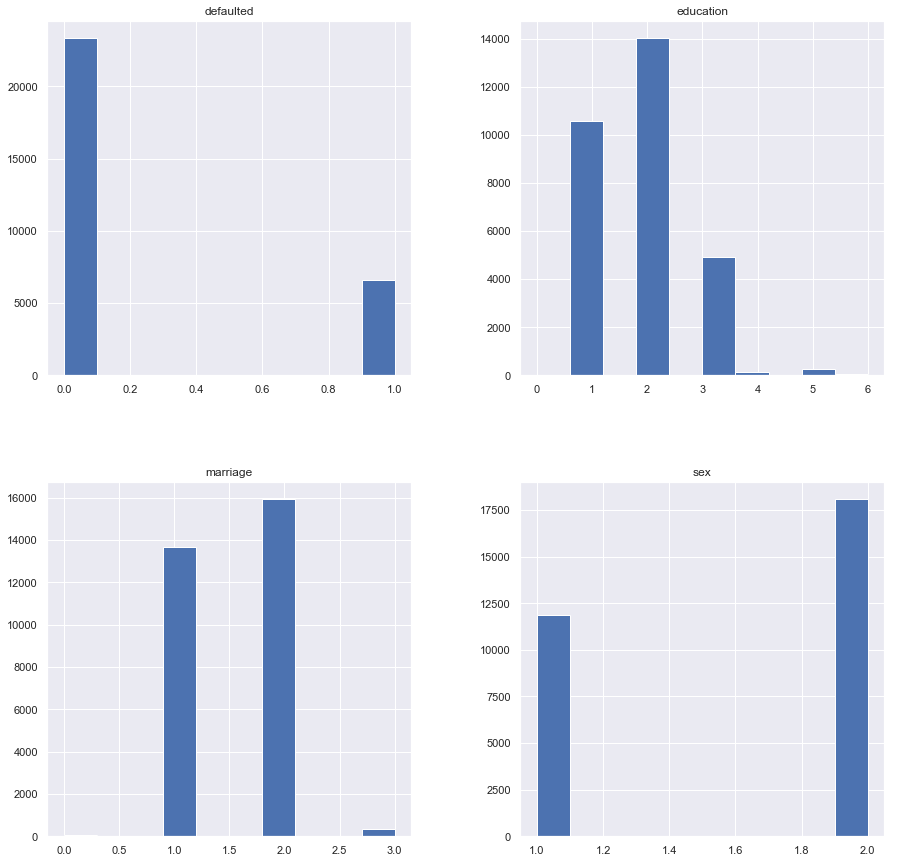

In [10]:
creditData[['sex', 'education', 'marriage','defaulted']].hist(figsize=(15,15))

## Variable Types:
### Continuous:

'limit_bal', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'

### Categorical:
'sex', 'education', 'marriage'

### Target:
'defaulted'

## Preprocessing steps:
- Normalizing Continuous variables
- One Hot Encoding for Categorical
- Data Pre-processesing

In [11]:
creditData.loc[creditData["sex"]==2,"sex"] = 0

In [12]:
ageGrps = list(range(20,85,5))
ageCrediters = pd.cut(creditData.age,ageGrps).to_frame()
ageCrediters.columns = ["age_range"]
creditData = pd.concat([creditData,ageCrediters],axis=1)

In [13]:
creditData.age_range = creditData.age_range.astype('str')

### One hot Encoding

In [14]:
df = pd.get_dummies(creditData["marriage"])
df.columns = ['marriage_unk','marriage_married', 'marriage_single','marriage_others']
creditData = pd.concat([creditData,df],axis=1)

In [15]:
creditData["education_grad"] = 0
creditData["education_university"] = 0
creditData["education_hs"] = 0
creditData["education_others"] = 0
creditData["education_ukn"] = 0
creditData.loc[creditData["education"]==1,"education_grad"] = 1
creditData.loc[creditData["education"]==2,"education_university"] = 1
creditData.loc[creditData["education"]==3,"education_hs"] = 1
creditData.loc[creditData["education"]==4,"education_others"] = 1
creditData.loc[creditData["education"]==5,"education_ukn"] = 1
creditData.loc[creditData["education"]==0,"education_ukn"] = 1
creditData.loc[creditData["education"]==6,"education_ukn"] = 1

In [16]:
df = pd.get_dummies(creditData.age_range)
df.columns = ['age_(20, 25]', 'age_(25, 30]', 'age_(30, 35]', 'age_(35, 40]', 'age_(40, 45]', 'age_(45, 50]','age_(50, 55]', 'age_(55, 60]', 'age_(60, 65]', 'age_(65, 70]', 'age_(70, 75]', 'age_(75, 80]']
creditData = pd.concat([creditData,df],axis=1)

### Standardization

In [17]:
creditData.loc[:, continuousCols] = StandardScaler().fit_transform(creditData.loc[:, continuousCols].values)

c:\users\humayra\miniconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
features = ['limit_bal', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'marriage_unk', 'marriage_married',
        'education_grad',
       'education_university', 'education_others',
       'education_ukn', 'age_(20, 25]', 'age_(25, 30]',
       'age_(30, 35]', 'age_(35, 40]', 'age_(40, 45]', 'age_(45, 50]',
       'age_(50, 55]', 'age_(55, 60]', 'age_(60, 65]', 'age_(65, 70]',
       'age_(70, 75]']

### Correlation Analysis

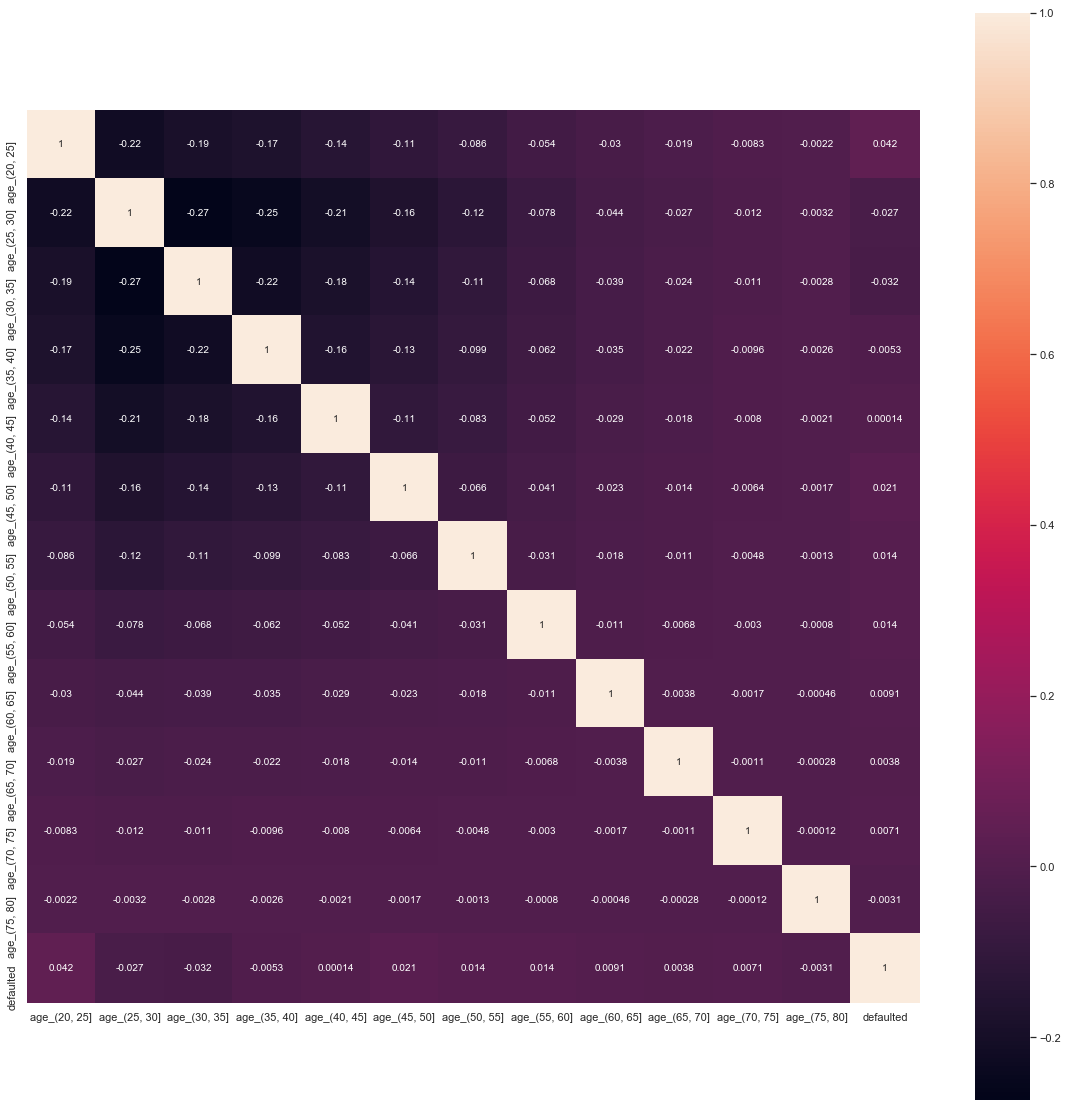

In [19]:
plt.figure(figsize=(20,20))
heat = sns.heatmap(creditData[['age_(20, 25]', 'age_(25, 30]',
       'age_(30, 35]', 'age_(35, 40]', 'age_(40, 45]', 'age_(45, 50]',
       'age_(50, 55]', 'age_(55, 60]', 'age_(60, 65]', 'age_(65, 70]',
       'age_(70, 75]', 'age_(75, 80]','defaulted']].corr(), vmax=1, square=True, annot=True)

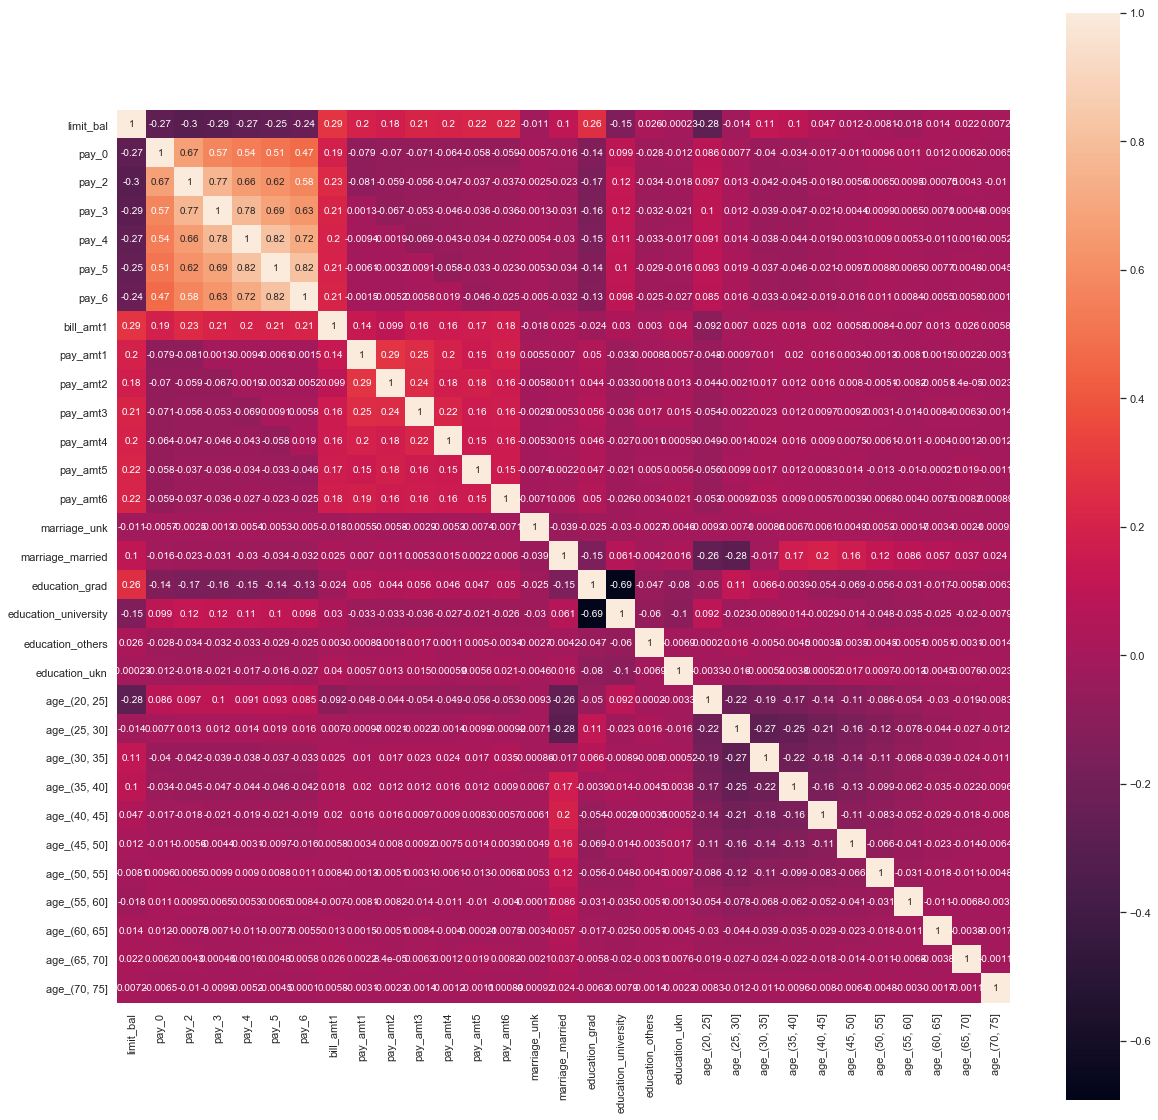

In [20]:
plt.figure(figsize=(20,20))
heat = sns.heatmap(creditData[features].corr(), vmax=1, square=True, annot=True)

### Prepping data for model


In [21]:
data = creditData[features+["defaulted"]]

In [22]:
trainData = data.sample(frac=.70) # random sampling of 70 of data
testData = data.loc[set(data.index)- set(trainData.index)] # picking the rest 30% of the data

In [23]:
XTrain = trainData[features].values
TTrain = trainData["defaulted"].values
XTest = testData[features].values
TTest = testData["defaulted"].values

# Method

I found this very helpful to explain Neural Network. 

![68747470733a2f2f63616d6f2e67697468756275736572636f6e74656e742e636f6d2f333165323031373265336237626335353330613665376337653733333965386535353664306163632f36383734373437303361326632663737373737373265363137333639366436](https://user-images.githubusercontent.com/14244685/79998273-501d7200-84dc-11ea-8de0-a09640f58f21.png)



## A Straight graph based model
- 5 hidden + 1 input + 1 output layers
- All hidden layers have equal number of nodes
- Chose this to understand how tensorflow works and it would be simple

In [24]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 5
n_hidden2 = 5
n_hidden3 = 5
n_hidden4 = 5
n_hidden5 = 5
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 1000

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [25]:
show_graph(tf.get_default_graph())

In [26]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8006667


Text(0,0.5,'Accuracy Ratio')

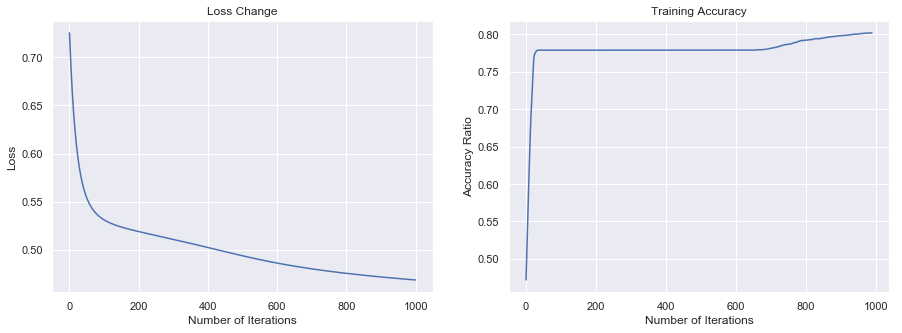

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

**Increased Number of Iterations:**
- Improved accuracy
- Takes longer time
- Improvement was not too much, so we have take of the trade of

In [28]:
n_epochs=3000
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.81655556


Text(0,0.5,'Accuracy Ratio')

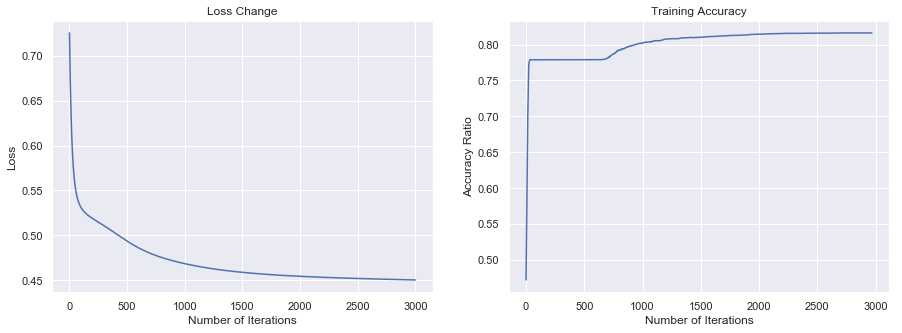

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

# Criss Cross and then narrowing
- 7 hidden (4 Criss Cross + 3 narrow ) + 1 input + 1 output layers
- Chose this structure to see how data expands and contracts (Encode and Decode) effect which later on converges

In [30]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 31
n_hidden2 = 16
n_hidden3 = 31
n_hidden4 = 16
n_hidden5 = 8
n_hidden6 = 6
n_hidden7 = 4
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=selu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=selu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=selu, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=selu, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=selu, name="hidden7")
    logits = tf.layers.dense(hidden7, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [31]:
show_graph(tf.get_default_graph())

In [32]:

n_epochs = 1000

acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.81711113


Text(0,0.5,'Accuracy Ratio')

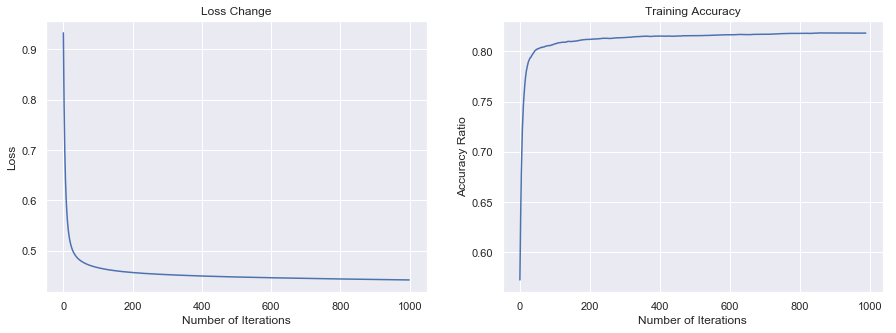

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

Increasing number of Iterations to a much significant number when number of layers have increased
- Here I see that accuracy remain unchanged
- But it takes a lot of time to finish training

In [34]:
n_epochs = 10000

acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8146667


Text(0,0.5,'Accuracy Ratio')

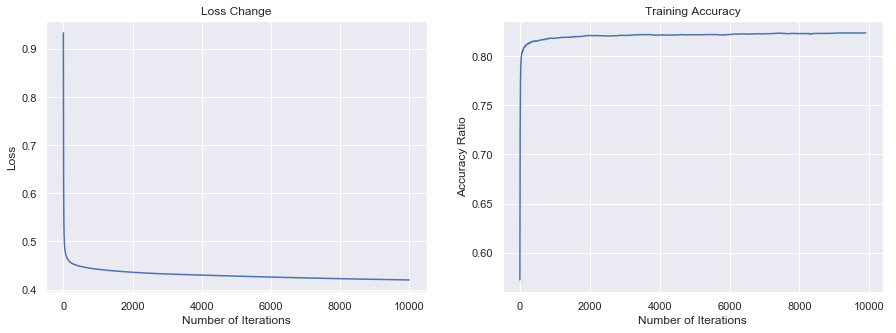

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")


# Only Criss Cross
- 6 hidden + 1 input + 1 output layers
- Chose this structure to see how data expands and contracts (Encode and Decode) effect alone

In [36]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 15
n_hidden2 = 5
n_hidden3 = 15
n_hidden4 = 5
n_hidden5 = 15
n_hidden6 = 5
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):

    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.tanh, name="hidden6")
    logits = tf.layers.dense(hidden6, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 1000

In [37]:
show_graph(tf.get_default_graph())

In [38]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8092222


Text(0,0.5,'Accuracy Ratio')

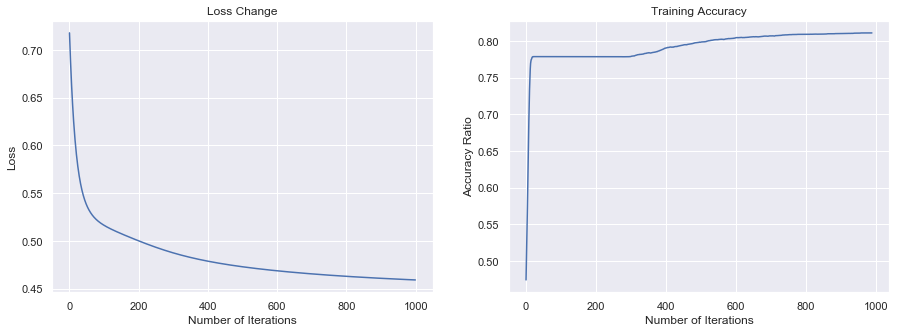

In [39]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

# Only Narrowing
- 6 hidden + 1 input + 1 output layers
- Chose this structure to see how echoing with reduced dimensionality of data affects classification

In [40]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 31
n_hidden2 = 25
n_hidden3 = 20
n_hidden4 = 15
n_hidden5 = 10
n_hidden6 = 5
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):

    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.tanh, name="hidden6")
    logits = tf.layers.dense(hidden6, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 1000

In [41]:
show_graph(tf.get_default_graph())

In [42]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.81277776


Text(0,0.5,'Accuracy Ratio')

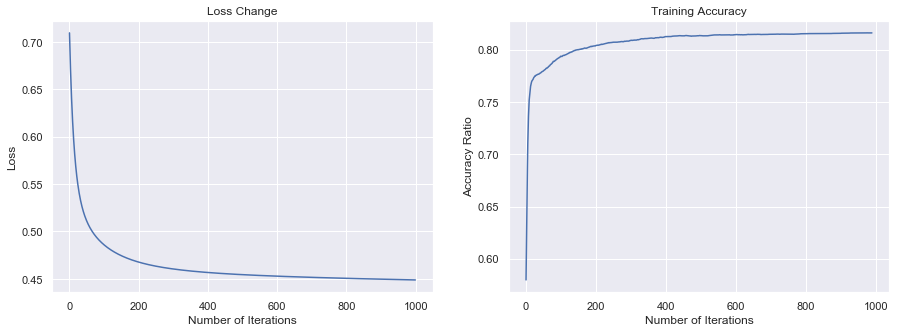

In [43]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

# Contraction and then Expansion
- 7 hidden + 1 input + 1 output layers
- First Data contracts for dew layers and then data expands
- Chose this structure to see how echoing with reduced dimensionality of data affects classification

In [44]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 20
n_hidden2 = 15
n_hidden3 = 10
n_hidden4 = 2
n_hidden5 = 10
n_hidden6 = 15
n_hidden7 = 20
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=selu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=selu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=selu, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=selu, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=selu, name="hidden7")
    logits = tf.layers.dense(hidden7, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
show_graph(tf.get_default_graph())

In [46]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.813


Text(0,0.5,'Accuracy Ratio')

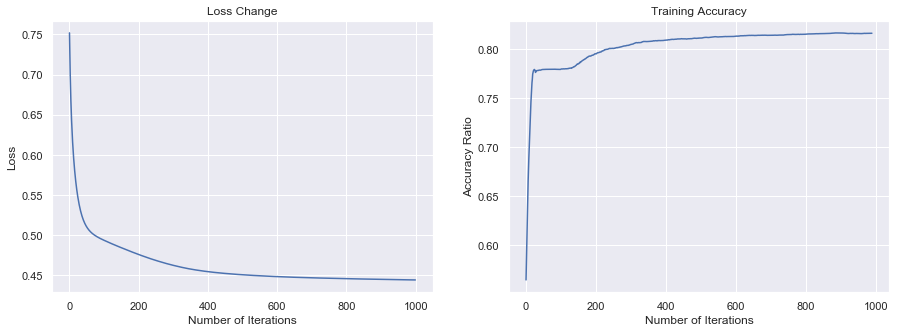

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

In [48]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 20
n_hidden2 = 15
n_hidden3 = 10
n_hidden4 = 2
n_hidden5 = 10
n_hidden6 = 15
n_hidden7 = 20
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.tanh, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=tf.tanh, name="hidden7")
    logits = tf.layers.dense(hidden7, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [49]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8152222


Text(0,0.5,'Accuracy Ratio')

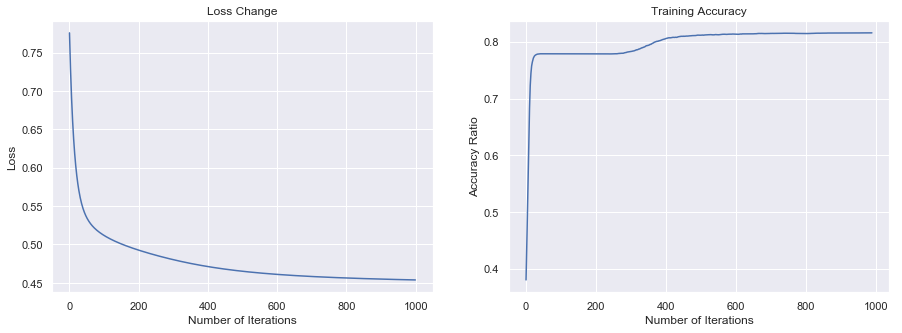

In [50]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

In [51]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 20
n_hidden2 = 15
n_hidden3 = 10
n_hidden4 = 2
n_hidden5 = 10
n_hidden6 = 15
n_hidden7 = 20
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=selu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=selu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=selu, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=selu, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=selu, name="hidden7")
    logits = tf.layers.dense(hidden7, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [52]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.7968889


Text(0,0.5,'Accuracy Ratio')

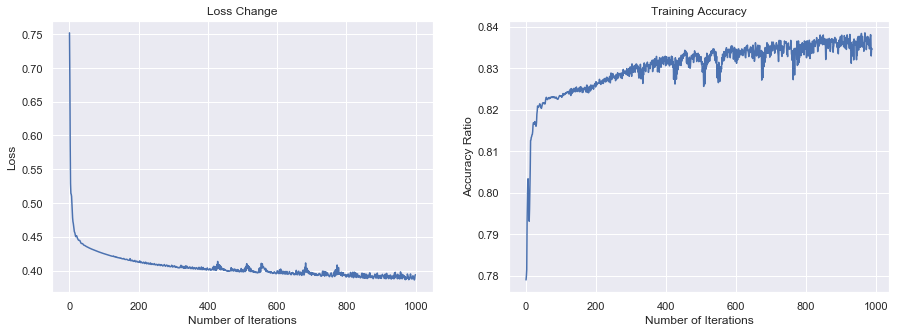

In [53]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

# Checking how testing accuracy after every 100 iterations

In [54]:
acc_train=[]
acc_test = []
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
            acc_test.append(accuracy.eval(feed_dict={X: XTest, y: TTest}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.7968889


Text(0,0.5,'Accuracy Ratio')

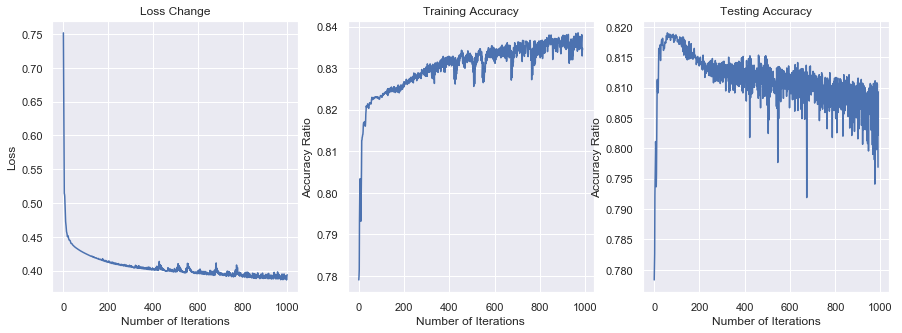

In [55]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,3,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")
plt.subplot(1,3,3)
plt.plot(acc_test)
plt.title("Testing Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

# Results Discussion:

- All these structures gave me accuracies that were very close to each other
- Contraction and then Expansion gave the best result, so I will change some parameters and see if value changes
- You see sudden improvement in training accuracy and quick drop in loss as well
- Iterations is not the cause for this accuracy
- If we compare at 500 iteration then we can wee that 2 structures are still trying to learn and improve but other structures just learn very quickly and then become stable
- Adam Optimizer is slow than Gradient Descent
    - It fluctuates a lot
- Relu is better than tanh also tested



Understanding the structure with personal Biases

- Now, I was trying to form structures by some intuional assumptions.
- Idea is that each layer is useful in understanding the data
- Adding more layer means finding some of the combinations of these columns aggregated based on some weights.
- Now, I interpreted reducing number of nodes in a layer means reducing dimentionality and vice versa

My opinions

- I guess these structures are giving very similar results because small number of data points.
- Or it can be some parameters as well.